In [1]:
# ✅ ライブラリ読み込みと初期設定
import pandas as pd
import numpy as np
from isodate import parse_duration
from janome.tokenizer import Tokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from PIL import Image
import requests
from io import BytesIO
import cv2
import mediapipe as mp
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# ✅ サムネイル特徴量カラム名定義
thumbnail_cols = [
    "brightness", "face_count", "telop_ratio",
    "r_mean", "g_mean", "b_mean",
    "h_mean", "s_mean", "v_mean"
] + [f"color_ratio_{i}" for i in range(5)]

# ✅ サムネイル特徴量抽出関数（バランス型）
def extract_all_thumbnail_features_mediapipe(url):
    try:
        response = requests.get(url, timeout=10)
        image = Image.open(BytesIO(response.content)).convert("RGB").resize((128, 128))
        img_np = np.array(image)

        hsv = cv2.cvtColor(img_np, cv2.COLOR_RGB2HSV)
        brightness = hsv[:, :, 2].mean()

        r_mean = img_np[:, :, 0].mean()
        g_mean = img_np[:, :, 1].mean()
        b_mean = img_np[:, :, 2].mean()
        h_mean = hsv[:, :, 0].mean()
        s_mean = hsv[:, :, 1].mean()
        v_mean = hsv[:, :, 2].mean()

        pixels = img_np.reshape(-1, 3).astype(np.float32)
        _, labels, _ = cv2.kmeans(pixels, 5, None,
                                  (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2),
                                  10, cv2.KMEANS_RANDOM_CENTERS)
        color_ratios = [np.sum(labels.flatten() == i) / len(labels) for i in range(5)]

        gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
        _, thresh = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY)
        telop_ratio = np.sum(thresh == 255) / thresh.size

        mp_face_detection = mp.solutions.face_detection
        with mp_face_detection.FaceDetection(model_selection=1, min_detection_confidence=0.5) as fd:
            results = fd.process(cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR))
            face_count = len(results.detections) if results.detections else 0

        return [
            brightness, face_count, telop_ratio,
            r_mean, g_mean, b_mean, h_mean, s_mean, v_mean
        ] + color_ratios

    except:
        return [0] * len(thumbnail_cols)

# ✅ データ読み込みと前処理
df = pd.read_excel("youtube_dataset_20250731.xlsx")
df["title"] = df["title"].fillna("")
df["categoryId"] = pd.to_numeric(df["categoryId"], errors="coerce").fillna(-1).astype(int)
df["viewCount"] = pd.to_numeric(df["viewCount"], errors="coerce").fillna(0)
df["publishedAt"] = pd.to_datetime(df["publishedAt"], utc=True)
df["duration_seconds"] = df["duration"].apply(lambda x: parse_duration(x).total_seconds() if pd.notnull(x) else 0)
df = df[df["duration_seconds"] > 60].copy()  # Shorts除外

# ✅ 投稿時間特徴量 & 経過日数
now = pd.Timestamp.now(tz="UTC")
df["weekday"] = df["publishedAt"].dt.weekday
df["hour"] = df["publishedAt"].dt.hour
df["is_weekend"] = df["weekday"].isin([5, 6]).astype(int)
df["is_month_start"] = df["publishedAt"].dt.is_month_start.astype(int)
df["is_month_end"] = df["publishedAt"].dt.is_month_end.astype(int)
df["days_since_posted"] = (now - df["publishedAt"]).dt.days

# ✅ サムネイル特徴量がなければ抽出
if not set(thumbnail_cols).issubset(df.columns):
    if "thumbnail" not in df.columns:
        raise ValueError("⚠️ 'thumbnail'列がデータに存在しません")
    features = []
    for url in tqdm(df["thumbnail"], desc="🔍 サムネイル特徴量抽出中"):
        features.append(extract_all_thumbnail_features_mediapipe(url))
    thumbnail_df = pd.DataFrame(features, columns=thumbnail_cols)
    df = pd.concat([df.reset_index(drop=True), thumbnail_df], axis=1)

# ✅ 特徴量定義
feature_cols = [
    "categoryId", "weekday", "hour", "is_weekend",
    "is_month_start", "is_month_end", "days_since_posted"
] + thumbnail_cols

# ✅ TF-IDF（タイトル）
tokenizer = Tokenizer()
def tokenize_japanese(text):
    return [token.base_form for token in tokenizer.tokenize(text)
            if token.part_of_speech.split(',')[0] in ['名詞', '動詞', '形容詞']]

vectorizer = TfidfVectorizer(tokenizer=tokenize_japanese, token_pattern=None, max_features=100)

# ✅ 学習データ・テストデータ分割（7月以降は予測対象）
cutoff = pd.to_datetime("2025-07-01", utc=True)
df_train = df[df["publishedAt"] < cutoff].copy()
df_test = df[df["publishedAt"] >= cutoff].copy()

tfidf_train = vectorizer.fit_transform(df_train["title"])
tfidf_test = vectorizer.transform(df_test["title"])
tfidf_df_train = pd.DataFrame(tfidf_train.toarray(), columns=[f"tfidf_{w}" for w in vectorizer.get_feature_names_out()])
tfidf_df_test = pd.DataFrame(tfidf_test.toarray(), columns=tfidf_df_train.columns)
tfidf_df_train.index = df_train.index
tfidf_df_test.index = df_test.index

# ✅ 特徴量統合 & 学習
X_train = pd.concat([df_train[feature_cols].reset_index(drop=True), tfidf_df_train.reset_index(drop=True)], axis=1)
y_train = np.log1p(df_train["viewCount"])
X_test = pd.concat([df_test[feature_cols].reset_index(drop=True), tfidf_df_test.reset_index(drop=True)], axis=1)
y_test = df_test["viewCount"]

model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)
log_preds = model.predict(X_test)
view_preds = np.expm1(log_preds).astype(int)

# ✅ 結果表示
df_result = df_test[["title", "publishedAt", "viewCount"]].copy()
df_result["predicted_viewCount"] = view_preds
df_result["abs_error"] = (df_result["predicted_viewCount"] - df_result["viewCount"]).abs()
df_result = df_result.sort_values("publishedAt", ascending=False).reset_index(drop=True)
print(df_result.head(10))


🔍 サムネイル特徴量抽出中: 100%|█████████████████████████████████████████████████████| 951/951 [08:56<00:00,  1.77it/s]


                                               title  \
0  【清純売りYouTuberいけちゃんの不倫発覚/DJふぉい年末解散ライブへの出演を発表/テオ...   
1                        遂に決着がついてしまった件について。【真夏の喧嘩祭り】   
2                           コムドットの漫才が酷すぎると話題なので見てみた。   
3                       YouTube界に『歌ってみた』が帰ってきた件について。   
4                           啓之輔選手から本当にDM来てしまった件について。   
5                     ジュンの格闘技イキリが啓之輔選手に届いてしまった件について。   
6               【リボーンりょうすけが個人チャンネル開設】脱退の一途なのか？分析します。   
7                     リボーンが登録者購入疑惑で炎上している件について分析します。   
8  【アマリザのブレイキングダウン結果速報/ぷろたん&Rちゃん炎上/水溜まりボンドトミー炎上】漢だよ。   
9                        裏方の石田が人生で一度も破産したことがない件について。   

                publishedAt  viewCount  predicted_viewCount  abs_error  
0 2025-07-29 12:01:49+00:00     312205               362775      50570  
1 2025-07-27 12:01:40+00:00     351693               362772      11079  
2 2025-07-26 12:01:52+00:00     571930               373706     198224  
3 2025-07-23 12:01:59+00:00     320886               354017      33131  
4 2025-07-21 12:01

In [3]:
from sklearn.metrics import mean_squared_error
import numpy as np

# logスケール RMSE
rmse_log = np.sqrt(mean_squared_error(np.log1p(y_test), log_preds))
print(f"📉 RMSE（logスケール）: {rmse_log:.4f}")

# 元スケール RMSE
rmse_linear = np.sqrt(mean_squared_error(y_test, view_preds))
print(f"📈 RMSE（元スケール）: {rmse_linear:.2f}")



📉 RMSE（logスケール）: 0.5021
📈 RMSE（元スケール）: 115066.68


C:\Users\Owner\AppData\Local\Temp\ipykernel_12156\3336188431.py:11: UserWarning: Glyph 32670 (\N{CJK UNIFIED IDEOGRAPH-7F9E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Owner\AppData\Local\Temp\ipykernel_12156\3336188431.py:11: UserWarning: Glyph 24677 (\N{CJK UNIFIED IDEOGRAPH-6065}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Owner\AppData\Local\Temp\ipykernel_12156\3336188431.py:11: UserWarning: Glyph 20849 (\N{CJK UNIFIED IDEOGRAPH-5171}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Owner\AppData\Local\Temp\ipykernel_12156\3336188431.py:11: UserWarning: Glyph 24863 (\N{CJK UNIFIED IDEOGRAPH-611F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Owner\AppData\Local\Temp\ipykernel_12156\3336188431.py:11: UserWarning: Glyph 24112 (\N{CJK UNIFIED IDEOGRAPH-5E30}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Owner\AppData\Local\Temp\ipykernel_12156\3336188431.py:11: UserWarning: Glyph 23429 (\

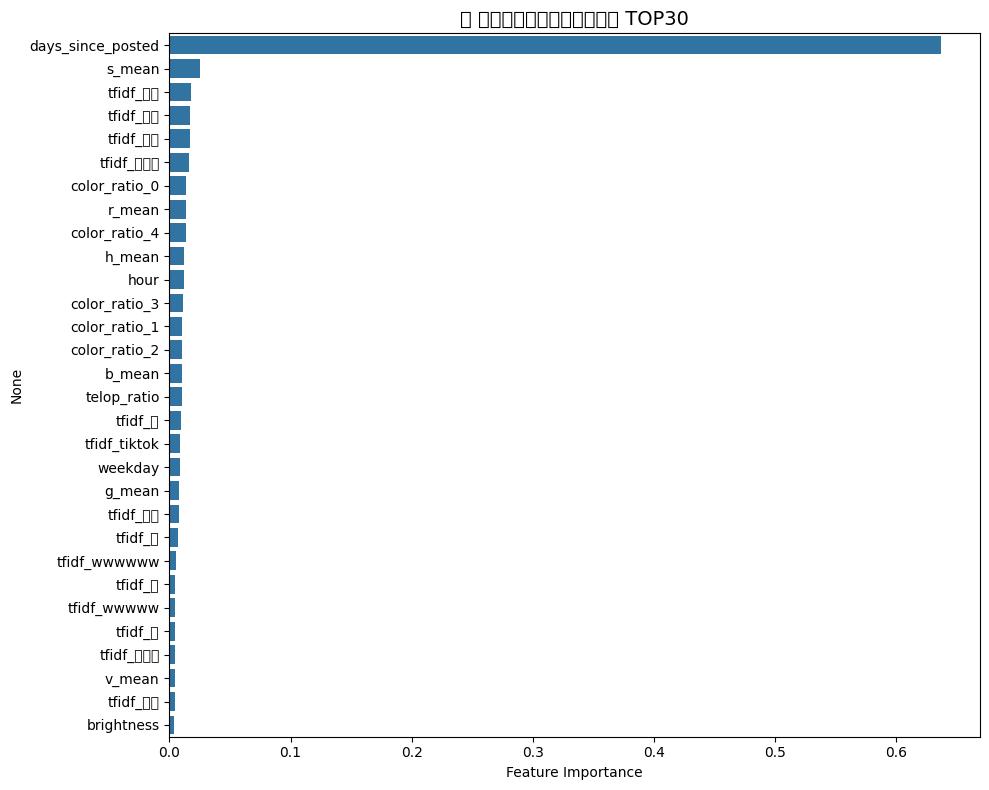

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

importance = pd.Series(model.feature_importances_, index=X_train.columns)
top_imp = importance.sort_values(ascending=False).head(30)

plt.figure(figsize=(10, 8))
sns.barplot(x=top_imp.values, y=top_imp.index)
plt.title("🔍 モデルに効いている特徴量 TOP30", fontsize=14)
plt.xlabel("Feature Importance")
plt.tight_layout()
plt.show()
